# Predicting shelter animals' fate 

This Notebook explores the `Shelter Animal Outcomes` dataset, published for a [Kaggle competition](https://www.kaggle.com/c/shelter-animal-outcomes/data). It is used for predicting the fate of shelter animals. 

It is explained that every year, approximately 7.6 million companion animals end up in US shelters. Many are given up as unwanted by their owners, while others are picked up after getting lost or taken out of cruelty situations. Dataset authors belive that it can help for understanding trends in animal outcomes. These insights could help shelters focus their energy on specific animals who need a little extra help for finding a new home. 

Kaggle's data contain training and testing sets with information from October 1st, 2013 to March, 2016. There is a sample sumbission form, too. These files are explored below; it is assumed that features such as pet's age, gender, breed, and color could predict its fate, e.g., handed for adoption, returned to owners, etc. Therefore, more than 2 possible outcomes suggests a multiclass classification tasks; a solution was sought by applying several machine learning algorithms. 

The work is organised in chapters and sub-chapters, each devoted to a particular task.

#### Imports

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

In [3]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import make_scorer, f1_score, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

In [4]:
pd.options.mode.chained_assignment = None

## I. Load data
### I.1. Train dataset

The dataset was downloaded from Kaggle to a local machine and stored in a folder. Thereafter, the train data were loaded and stored in `train_data`. The first 5 rows are printed below.

In [5]:
train_data = pd.read_csv("data/train.csv")

In [6]:
train_data.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan


The train dataset has 26729 entries (rows) and 10 categorical features (columns).

In [7]:
train_data.shape

(26729, 10)

### I.2. Test dataset

Similarly, the test data were loaded and stored in `test_data`. A brief check shows that besides "OutcomeType" (which would be the `labels` column), it lacks "AnimalID" and "OutcomeSubtype" features. It could be assumed that the former is a unique number each pet gets when admitted to the shelter, and the latter provides additional information about an animal's fate. On the other hand, the testing dataset has an "ID" column, which misses in the training data.

In [8]:
test_data = pd.read_csv("data/test.csv")

In [9]:
test_data.head()

,ID,Name,DateTime,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,1,Summer,2015-10-12 12:15:00,Dog,Intact Female,10 months,Labrador Retriever Mix,Red/White
1,2,Cheyenne,2014-07-26 17:59:00,Dog,Spayed Female,2 years,German Shepherd/Siberian Husky,Black/Tan
2,3,Gus,2016-01-13 12:20:00,Cat,Neutered Male,1 year,Domestic Shorthair Mix,Brown Tabby
3,4,Pongo,2013-12-28 18:12:00,Dog,Intact Male,4 months,Collie Smooth Mix,Tricolor
4,5,Skooter,2015-09-24 17:59:00,Dog,Neutered Male,2 years,Miniature Poodle Mix,White


There are 11456 testing entries, described with 8 features.

In [10]:
test_data.shape

(11456, 8)

### I.3. Sample submission

Kaggle provided a template for submitting predictions. Its first 5 rows are displayed below.

In [11]:
sample_sumbission = pd.read_csv("data/sample_submission.csv")

In [12]:
sample_sumbission.head()

,ID,Adoption,Died,Euthanasia,Return_to_owner,Transfer
0,1,1,0,0,0,0
1,2,1,0,0,0,0
2,3,1,0,0,0,0
3,4,1,0,0,0,0
4,5,1,0,0,0,0


## II. Exploratory Data Analysis. Cleaning data

A quick training data summary is displayed below. Figures in "count" indicate that some features has a lot of missing values, which are handled in subsequent sub-chapters.

In [13]:
train_data.describe().T

,count,unique,top,freq
AnimalID,26729,26729,A688558,1
Name,19038,6374,Max,136
DateTime,26729,22918,2015-08-11 00:00:00,19
OutcomeType,26729,5,Adoption,10769
OutcomeSubtype,13117,16,Partner,7816
AnimalType,26729,2,Dog,15595
SexuponOutcome,26728,5,Neutered Male,9779
AgeuponOutcome,26711,44,1 year,3969
Breed,26729,1380,Domestic Shorthair Mix,8810
Color,26729,366,Black/White,2824


### II.1 Insert `ID` column in Train data

It is important both training and testing data to have identical features. Otherwise, any machine learning algorithm will throw a shape error. For this reason, the code line below inserts an "ID" column with values starting from 1 (as those in the testing set).

In [14]:
train_data.insert(0, "ID", range(1, 1 + len(train_data)))

In [15]:
train_data.head()

,ID,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,1,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,2,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,3,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
3,4,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
4,5,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan


### II. 2. Remove unnecessary columns

Testing data doesn't have "OutcomeSubtype". The latter contains additional information about outcomes: some adopted pets went to foster homes or barns; some died at the veterinary clinic, others were euthanised because were too agressive or ill. This information misses in the testing data and cannot be infered from "OutcomeType". For this reason, along with "AnimalID", "OutcomeSubtype" was also removed.

In [16]:
train_data.groupby("OutcomeType").OutcomeSubtype.unique().reset_index()

,OutcomeType,OutcomeSubtype
0,Adoption,"[Foster, nan, Offsite, Barn]"
1,Died,"[In Kennel, In Foster, nan, Enroute, At Vet, I..."
2,Euthanasia,"[Suffering, Aggressive, Behavior, Rabies Risk,..."
3,Return_to_owner,[nan]
4,Transfer,"[Partner, SCRP, Barn, nan]"


In [17]:
train_data.drop(["AnimalID", "OutcomeSubtype"], axis = 1, inplace = True)

### II.3. Explore and clean columns
#### II.3.a. `DateTime` column

`DateTime` information is provided in the following format: *YYYY-MM-DD HH:MM:SS*. It could be assumed that a public campaign held somewhere in 2014, for example, could have led to higher pet adoption rates. However, dates and time could hardly affect a shelter outcome. For this reason, only years and months were kept in the data. The function below extracts useful information and add it to the table.

In [18]:
def format_time(dataset):
    """
    Function: Extracts year and month from "DateTime" and removes "DateTime"
    
    Arguments: Dataset with "DateTime" column
    
    Returns: Dataset with "year" and "month"
    """
    dataset[["year", "month", "day_hour"]] = dataset["DateTime"].str.split("-", expand = True)
    dataset.drop(["DateTime", "day_hour"], axis = 1, inplace = True)
    
    return dataset

In [19]:
train_data = format_time(train_data)
test_data = format_time(test_data)

In [20]:
test_data.head()

,ID,Name,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,year,month
0,1,Summer,Dog,Intact Female,10 months,Labrador Retriever Mix,Red/White,2015,10
1,2,Cheyenne,Dog,Spayed Female,2 years,German Shepherd/Siberian Husky,Black/Tan,2014,07
2,3,Gus,Cat,Neutered Male,1 year,Domestic Shorthair Mix,Brown Tabby,2016,01
3,4,Pongo,Dog,Intact Male,4 months,Collie Smooth Mix,Tricolor,2013,12
4,5,Skooter,Dog,Neutered Male,2 years,Miniature Poodle Mix,White,2015,09


Visualizing data improves its understanding. To spare redundant coding, the function below helps for displaying occurrence of categorical variables. It is used for showing shelter outcomes per year and per month in both datasets.

In [21]:
def plot_bar(dataset, column, title = None, color = None):
    """
    Function: Plots categorical data
    
    Arguments: dataset, feature; title and color are optional
    
    Returns: Barplot of categorical variable
    """
    index = dataset.groupby(column).size().index
    feature = dataset.groupby(column).size()
    
    plt.bar(index, feature, color = color)
    plt.ylabel("Count")
    if title is not None:
        plt.title(title)
    plt.show()

Both datasets hold similar data in terms of the year and month the events occurred. As expected, there are less samples in 2013 and 2016 but almost equal number of records in 2014 and 2015.

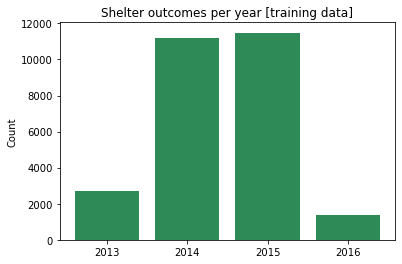

In [22]:
plot_bar(train_data, "year", "Shelter outcomes per year [training data]", "seagreen")

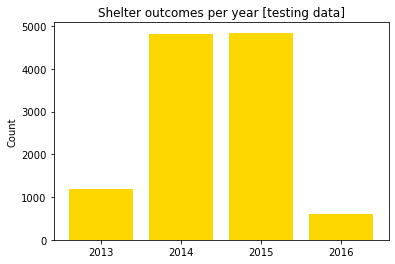

In [23]:
plot_bar(test_data, "year", "Shelter outcomes per year [testing data]", "gold")

Similarly, most cases were handled in October, November, and December, and least - in March.

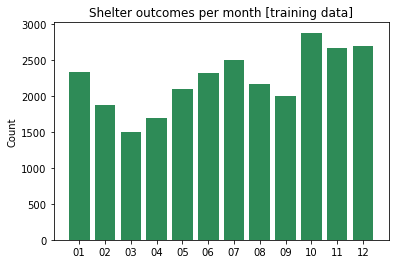

In [24]:
plot_bar(train_data, "month", "Shelter outcomes per month [training data]", "seagreen")

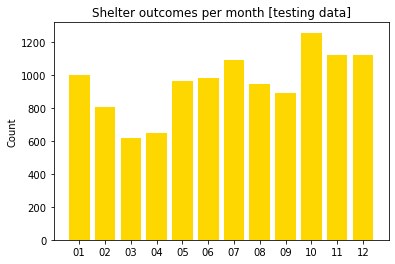

In [25]:
plot_bar(test_data, "month", "Shelter outcomes per month [testing data]", "gold")

#### II.3.b. `Name` column

A pet's name could hardly predict its fate. Furthermore, there are 6375 unique names in the training data, and 3713 - in the testing one; furthermore, both sets have missing values. For this reason, this column was removed.

In [26]:
len(train_data["Name"].unique()), len(test_data["Name"].unique())

(6375, 3713)

In [27]:
train_data["Name"].isna().any(), test_data["Name"].isna().any()

(True, True)

In [28]:
train_data.drop("Name", axis = 1, inplace = True)
test_data.drop("Name", axis = 1, inplace = True)

#### II.3.c. `AnimalType` column

Both sets hold data only for cats and dogs. A brief check shows that there aren't missing values. Dogs and Cats in training and testing data are counted and displayed below. Both datasets have similar distribution of felines and canines.

In [29]:
train_data["AnimalType"].unique(), test_data["AnimalType"].unique()

(array(['Dog', 'Cat'], dtype=object), array(['Dog', 'Cat'], dtype=object))

In [30]:
train_data["AnimalType"].isna().any(), test_data["AnimalType"].isna().any()

(False, False)

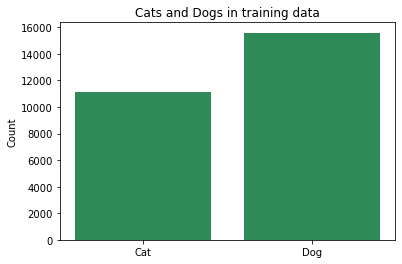

In [31]:
plot_bar(train_data, "AnimalType", "Cats and Dogs in training data", "seagreen")

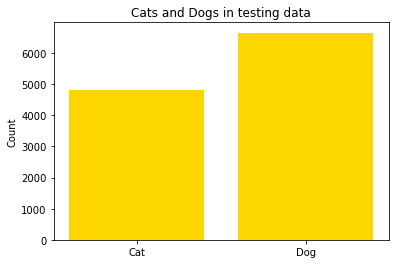

In [32]:
plot_bar(test_data, "AnimalType", "Cats and Dogs in testing data", "gold")

#### II.3.d. `SexuponOutcome` column

"SexuponOutcome" holds data as to if the animal was spayed/neutered or not. Information for some pets is unknown or lacking.

In [33]:
train_data["SexuponOutcome"].unique(), test_data["SexuponOutcome"].unique()

(array(['Neutered Male', 'Spayed Female', 'Intact Male', 'Intact Female',
        'Unknown', nan], dtype=object),
 array(['Intact Female', 'Spayed Female', 'Neutered Male', 'Intact Male',
        'Unknown'], dtype=object))

In fact, there is not data for only one dog. Therefore, the `NaN` value was replaced with "unknown", since machine learning algorithms cannot make computations with missing values.

In [34]:
train_data[train_data["SexuponOutcome"].isna()]

,ID,OutcomeType,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,year,month
3174,3175,Return_to_owner,Dog,NaN,7 years,Dachshund,Brown Merle,2013,11


In [35]:
train_data["SexuponOutcome"] = train_data["SexuponOutcome"].replace(np.nan, "Unknown")

The plots below show that most animals (both in the training and testing data) were neutered/spayed when left the shelter.

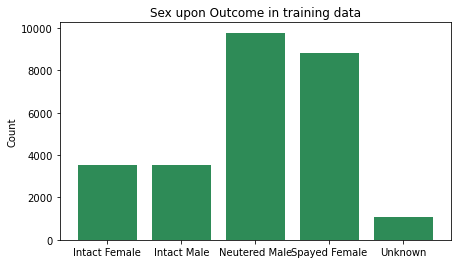

In [36]:
plt.figure(figsize = (7, 4))
plot_bar(train_data, "SexuponOutcome", "Sex upon Outcome in training data", "seagreen")

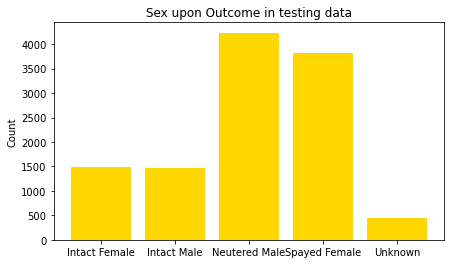

In [37]:
plt.figure(figsize = (7, 4))
plot_bar(test_data, "SexuponOutcome", "Sex upon Outcome in testing data", "gold")

Gender information could be further disaggregated by placing pets into female, male, neutered/spayed, or unknown group. This is performed with the code lines below.

In [38]:
def gender_procedure(gender, field):
    """
    Function: Splits animals gender and state / underwent procedure
    
    Arguments: gender and field
    
    Returns: Dataset with additional columns for gender and underwent procedure
    """
    if gender == "Unknown":
        return "Unknown"
    
    else:
        split_gender = gender.split(" ")
        if field == "gender":
            return split_gender[1]
        elif field == "state":
            return split_gender[0]

The function is applied to both datasets twice - once for getting gender, and second time - for storing information as to if the pet was spayed/neurtured, or not.

In [39]:
train_data["gender"] = train_data["SexuponOutcome"].apply(gender_procedure, args = ("gender",))
train_data["state"] = train_data["SexuponOutcome"].apply(gender_procedure, args = ("state",)) 

In [40]:
test_data["gender"] = test_data["SexuponOutcome"].apply(gender_procedure, args = ("gender",))
test_data["state"] = test_data["SexuponOutcome"].apply(gender_procedure, args = ("state",))

Thereafter, "SexuponOutcome" was removed; instead, "gender" and "state" are used for modeling.

In [41]:
train_data.drop("SexuponOutcome", axis = 1, inplace = True)
test_data.drop("SexuponOutcome", axis = 1, inplace = True)

#### II.3.e. `AgeuponOutcome` column

"AgeuponOutcome" provides information about the pet's age when it left the shelter, or when its case was closed. Unfortunately, age values were entered as strings and are in *days, weeks, months*, or *years*. There are missing values in both datasets, as well. The latter could be filled with the most frequent age but first, values should be converted.

In [42]:
train_data["AgeuponOutcome"].unique()

array(['1 year', '2 years', '3 weeks', '1 month', '5 months', '4 years',
       '3 months', '2 weeks', '2 months', '10 months', '6 months',
       '5 years', '7 years', '3 years', '4 months', '12 years', '9 years',
       '6 years', '1 weeks', '11 years', '4 weeks', '7 months', '8 years',
       '11 months', '4 days', '9 months', '8 months', '15 years',
       '10 years', '1 week', '0 years', '14 years', '3 days', '6 days',
       '5 days', '5 weeks', '2 days', '16 years', '1 day', '13 years',
       nan, '17 years', '18 years', '19 years', '20 years'], dtype=object)

In [43]:
test_data["AgeuponOutcome"].unique() 

array(['10 months', '2 years', '1 year', '4 months', '3 years',
       '13 years', '6 months', '3 months', '5 months', '5 years',
       '4 years', '3 weeks', '1 week', '2 months', '9 months', '4 days',
       '2 weeks', '7 months', '9 years', '1 month', '12 years', '1 weeks',
       '6 days', '6 years', '8 years', '8 months', '4 weeks', '7 years',
       '10 years', '5 days', '17 years', '3 days', '15 years', '11 years',
       '14 years', '11 months', nan, '2 days', '1 day', '16 years',
       '20 years', '0 years', '22 years', '18 years', '5 weeks',
       '19 years'], dtype=object)

It seems the easiest way to make pets' age comparable is to convert all values into weeks. Thus, a year old puppy would be 52 weeks old, and a month old cat - 4 weeks of age. Newborn animals (i.e., a-few-days old) get 0.9 weeks as their age, which is less than 1 week. `NaN` values are handled later.

The code lines below get all ages in a list and check if the entry contains the respective word. If so, the value is multiplied by 1 (for week), 4 (for months), and 52 (for years), or is directly assigned 0.9.

In [44]:
def convert_age(dataset, age_col):
    """
    Function: Converts different age format into weeks
    
    Arguments: dataset and column with age data
    
    Returns: Dataset with new column for age in weeks
    """
    output_age_weeks = []
    age_column = dataset[age_col].tolist()
    
    for record in age_column:
        if type(record) == float:
            formated_age = None
        else:
            if "month" in record:
                formated_age = round(float(record[0]) * 4)
            elif "week" in record:
                formated_age = round(float(record[0]) * 1)
            elif "day" in record:
                formated_age = 0.9
            elif "year" in record:
                formated_age = round(float(record[0]) * 52)
        output_age_weeks.append(formated_age)
    
    dataset.drop(age_col, axis = 1, inplace = True)
    dataset["age_weeks"] = output_age_weeks
    
    return dataset

In [45]:
train_data = convert_age(train_data, "AgeuponOutcome")

In [46]:
test_data = convert_age(test_data, "AgeuponOutcome")

In [47]:
train_data.head()

,ID,OutcomeType,AnimalType,Breed,Color,year,month,gender,state,age_weeks
0,1,Return_to_owner,Dog,Shetland Sheepdog Mix,Brown/White,2014,02,Male,Neutered,52.0
1,2,Euthanasia,Cat,Domestic Shorthair Mix,Cream Tabby,2013,10,Female,Spayed,52.0
2,3,Adoption,Dog,Pit Bull Mix,Blue/White,2015,01,Male,Neutered,104.0
3,4,Transfer,Cat,Domestic Shorthair Mix,Blue Cream,2014,07,Male,Intact,3.0
4,5,Transfer,Dog,Lhasa Apso/Miniature Poodle,Tan,2013,11,Male,Neutered,104.0


In [48]:
train_data["age_weeks"].isna().any(), test_data["age_weeks"].isna().any()

(True, True)

To recall, there are missing values in the age column. All values are on the same scale now (so to speak), and `NaNs` could be imputed with the most frequent one. Mode is computed in the function below, which is used for imputing empty cells.

In [49]:
def impute_missing_values(dataset, age_col):
    """
    Function: Imputes missing values in age column with mode
    
    Arguments: dataset and column with age data
    
    Returns: Dataset without missing values in age column
    """
    mode_age = dataset[age_col].mode()[0]
    dataset[age_col] = dataset[age_col].fillna(mode_age)
    
    return dataset

In [50]:
train_data = impute_missing_values(train_data, "age_weeks")

In [51]:
test_data = impute_missing_values(test_data, "age_weeks")

A brief check confirms that there are not missing values anymore.

In [52]:
train_data["age_weeks"].isna().any(), test_data["age_weeks"].isna().any()

(False, False)

It is interesting to see how old pets were when left the shelter (or when their case was closed). The function below helps for displaying age distribution.

In [53]:
def plot_hist(dataset, column, title = None, color = None):
    """
    Function: Plots distribution of continuous values
    
    Arguments: dataset and column; title and color are optional
    
    Returns: Histogram of continuous values
    """
    plt.hist(dataset[column], color = color)
    if title is not None:
        plt.title(title)
    plt.ylabel("Count")
    plt.show()

Most animals were up to 200 weeks old (circa 4 years of age) when left the shelter or their case was closed.

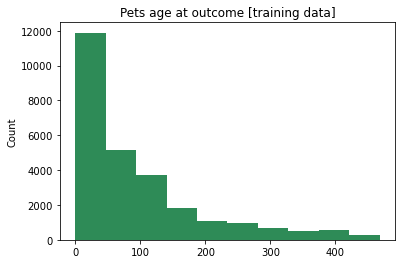

In [54]:
plot_hist(train_data, "age_weeks", "Pets age at outcome [training data]", "seagreen")

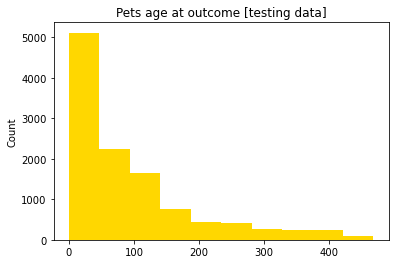

In [55]:
plot_hist(test_data, "age_weeks", "Pets age at outcome [testing data]", "gold")

#### II.3.f. `Breed` column

There are 1380 unique breed types in the training data, and 913 - in the testing part. It is possible to group them around words like "mix" but important information might be lost. For this reason, breeds will not be "cleaned" or re-grouped further. Fortunately, there are not missing values in this feature.

In [56]:
len(train_data["Breed"].unique()), len(test_data["Breed"].unique())

(1380, 913)

In [57]:
train_data["Breed"].isna().any(), test_data["Breed"].isna().any()

(False, False)

#### II.3.g. `Color` column

Similarly, pets come with various colors and stripes. As a result, there are 366 unique values in the training data, and 277 - in the testing one. Grouping animals around color, if possible at all, could lead to loss of information. Pets' appearace most likely (and unfortunately) play a role in adoption; hence, this feature must not be removed. Luckily, there are not missing values here, too.

In [58]:
len(train_data["Color"].unique()), len(test_data["Color"].unique())

(366, 277)

In [59]:
train_data["Color"].isna().any(), test_data["Color"].isna().any()

(False, False)

#### II.3.h. `Outcome` column

The "Outcome" for an animal leaving the shelter, could be: `Return to owner`, `Euthanasia`, `Adoption`, `Transfer`, and `Died`. Their frequency is ploted below. 

In [60]:
train_data["OutcomeType"].unique()

array(['Return_to_owner', 'Euthanasia', 'Adoption', 'Transfer', 'Died'],
      dtype=object)

Most pets were either adopted or transfered or returned to owners. Slightly less than 2000 animals were euthanised and a minor share simply died.

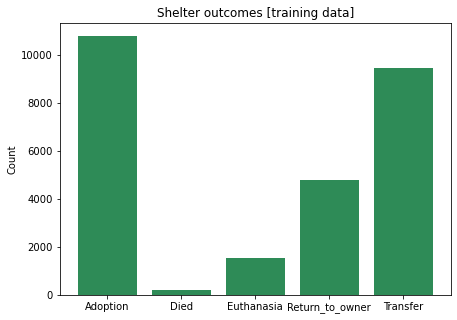

In [61]:
plt.figure(figsize = (7, 5))
plot_bar(train_data, "OutcomeType", "Shelter outcomes [training data]", "seagreen")

## III. Data Pre-processing
### III.1 Set `ID` for Index column

"ID" column contains unique numbers; if left as feature, the algorithm will use it as a predictor for the outcome, which would be wrong. On the other hand, the sample submission template requires outcomes to be provided with an "ID" column. For this reason, it is set for an index.

In [62]:
train_data.set_index("ID", inplace = True)

In [63]:
test_data.set_index("ID", inplace = True)

### III.2 Shuffle Train data

Train data will be split into training and validation. It is shuffled for avoiding over- or under sampling of certain classes (outcomes) during splitting. Thereafter, the first 5 rows of both datasets are displayed.

In [64]:
train_data_shuffled = train_data.sample(frac = 1).reset_index(drop = True)

In [65]:
train_data_shuffled.head()

,OutcomeType,AnimalType,Breed,Color,year,month,gender,state,age_weeks
0,Adoption,Cat,Domestic Shorthair Mix,White/Brown Tabby,2015,09,Male,Neutered,8.0
1,Adoption,Dog,Chihuahua Shorthair Mix,Tricolor,2015,01,Male,Neutered,468.0
2,Adoption,Dog,Miniature Poodle/Maltese,Cream,2015,06,Female,Spayed,104.0
3,Transfer,Cat,Domestic Shorthair Mix,Tortie,2014,05,Female,Intact,3.0
4,Adoption,Cat,Domestic Shorthair Mix,Black/White,2014,07,Female,Spayed,4.0


In [66]:
test_data.head()

,AnimalType,Breed,Color,year,month,gender,state,age_weeks
ID,,,,,,,,
1,Dog,Labrador Retriever Mix,Red/White,2015,10,Female,Intact,4.0
2,Dog,German Shepherd/Siberian Husky,Black/Tan,2014,07,Female,Spayed,104.0
3,Cat,Domestic Shorthair Mix,Brown Tabby,2016,01,Male,Neutered,52.0
4,Dog,Collie Smooth Mix,Tricolor,2013,12,Male,Intact,16.0
5,Dog,Miniature Poodle Mix,White,2015,09,Male,Neutered,104.0


Both sets have same features save the "OutcomeType" in the training data. The latter should be separated from other features before to proceed further.

### III.3. Separate labels from features

Labels are separated from features with the function below.

In [67]:
def separate_dataset(dataset, label_col):
    """
    Function: Separates labels from features
    
    Arguments: Dataset and column with labels
    
    Returns: Tuple with features and labels
    """
    features = dataset.drop(label_col, axis = 1)
    labels = dataset[label_col]
    
    return (features, labels)

In [68]:
(train_features, train_labels) = separate_dataset(train_data_shuffled, "OutcomeType")

A brief check shows that both sets have 8 identical features. "ID" column in training data changed but it is irrelevant for modeling and prediction.

In [69]:
train_features.head()

,AnimalType,Breed,Color,year,month,gender,state,age_weeks
0,Cat,Domestic Shorthair Mix,White/Brown Tabby,2015,09,Male,Neutered,8.0
1,Dog,Chihuahua Shorthair Mix,Tricolor,2015,01,Male,Neutered,468.0
2,Dog,Miniature Poodle/Maltese,Cream,2015,06,Female,Spayed,104.0
3,Cat,Domestic Shorthair Mix,Tortie,2014,05,Female,Intact,3.0
4,Cat,Domestic Shorthair Mix,Black/White,2014,07,Female,Spayed,4.0


In [70]:
test_data.head()

,AnimalType,Breed,Color,year,month,gender,state,age_weeks
ID,,,,,,,,
1,Dog,Labrador Retriever Mix,Red/White,2015,10,Female,Intact,4.0
2,Dog,German Shepherd/Siberian Husky,Black/Tan,2014,07,Female,Spayed,104.0
3,Cat,Domestic Shorthair Mix,Brown Tabby,2016,01,Male,Neutered,52.0
4,Dog,Collie Smooth Mix,Tricolor,2013,12,Male,Intact,16.0
5,Dog,Miniature Poodle Mix,White,2015,09,Male,Neutered,104.0


In [71]:
train_features.shape, test_data.shape

((26729, 8), (11456, 8))

### III.4. Split data into training and validation

Train data is used for training the model, and validation (15%) - for selecting the best performing one. A brief check confirms the splitting was properly made.

In [72]:
train_f, val_f, train_lb, val_lb = train_test_split(train_features, train_labels, 
                                            test_size = 0.15, stratify = train_labels)

In [73]:
train_f.shape, train_lb.shape, val_f.shape, val_lb.shape

((22719, 8), (22719,), (4010, 8), (4010,))

### III.5. Concatenate Train, Validation, and Test data

Categorical values should be converted in numerical ones. A better approach is to *one-hot-encode* them. However, it turned out that this approch wouldn't work since "Breed" and "Color" columns have many and different unique values; thus, `pd.get_dummies()` applied over training and testing data returned matrices of different shape. Neither model would be able to predict a probability over a matrix of shape *X* if trained on matrix of shape *Z*. For this reason, the less desirable approach - `LabelEncoder()` - is used instead. It assigns numeric values on each unique category.

To avoid missmatch during label encoding (since one set might not contain a given pet breed or color), all three are concatenated. Thus, the function takes into account all possible categorical values when replacing them with numbers. Inserting a new "set" column with "train", "val", and "test" values, respectively, makes possible splitting the dataset back again.

In [74]:
train_f["set"] = "train"
val_f["set"] = "val"
test_data["set"] = "test"

In [75]:
all_features = pd.concat([train_f, val_f, test_data])

### III.4. Encoding categorical variables

Five features hold categorical variables. `LabelEncoder()` should have been applied 5 times if all columns had to be treated separately. Instead, the function below (offered by a [StackOverflow](https://stackoverflow.com/questions/24458645/label-encoding-across-multiple-columns-in-scikit-learn) user) encodes all features at once.

In [76]:
class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self, X, y = None):
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)

In [77]:
all_features = MultiColumnLabelEncoder(columns = ["AnimalType", "Breed", "Color",
                                    "gender", "state"]).fit_transform(all_features)

Thereafter, the data are split back into training, validation, and testing, and the "set" column - removed.

In [78]:
train_f_encoded = all_features[all_features["set"] == "train"]
val_f_encoded = all_features[all_features["set"] == "val"]
test_f_encoded = all_features[all_features["set"] == "test"]

In [79]:
train_f_encoded.drop("set", axis = 1, inplace = True)
val_f_encoded.drop("set", axis = 1, inplace = True)
test_f_encoded.drop("set", axis = 1, inplace = True)

### III.5. Encoding labels

Labels are encoded separately. The code lines below replaces categorical "OutcomeType" with a numeric one.

In [80]:
label_encoder = LabelEncoder()

In [81]:
train_lab = label_encoder.fit_transform(train_lb)

In [82]:
val_lab = label_encoder.fit_transform(val_lb)

A brief check confirms the datasets are in the proper shape.

In [83]:
train_f_encoded.shape, train_lab.shape, val_f_encoded.shape, val_lab.shape

((22719, 8), (22719,), (4010, 8), (4010,))

### III.6. Scaling features

Numeric values in all features should be normalized, i.e., should be within one and the same range. This will prevent the machine learning algorithm to assign greater weight to larger values. For this reason, all values are scaled between 0 and 1. Normalization is performed with `MinMaxScaler()`.

In [84]:
scaler = MinMaxScaler()

In [85]:
train_f_scaled = scaler.fit_transform(train_f_encoded)
val_f_scaled = scaler.fit_transform(val_f_encoded)
test_f_scaled = scaler.fit_transform(test_f_encoded)

A brief check confirms the features were successfully normalized.

In [86]:
train_f_scaled.min(), train_f_scaled.max()

(0.0, 1.0)

## IV. Building and selecting a Classifier
### IV.1. Build a `base` model

A simple `LogisticRegression()` function will be used for base classification model. If performs well, it will predict the outcomes on the testing data; if not, other algorithms will be tried and tested. Models are tuned and evaluated according to their performance on `f1_score` - a harmonic mean of precision and recall - both classification metrics. It should be instantiated before being fed to the `GridSearchCV()` algorithm. The latter searches for the best performing model within a given range of pre-selected hyper-parameters. These are stored in a "params" dictionary. Searching is cross-validated over 4 folds; one is kept for validation.

In [87]:
f1 = make_scorer(f1_score , average = "weighted")

In [88]:
params_lg = {
    "penalty": ["l1", "l2"],
    "C": [0.1, 0.01, 0.001, 0.0001, 0.00001]}

In [89]:
grid_search_lg = GridSearchCV(LogisticRegression(solver = "liblinear"), 
                              param_grid = params_lg, 
                              scoring = f1, 
                              cv = 5)

##### Grid Search for best Logistic Regression model

In [90]:
grid_search_lg.fit(train_f_scaled, train_lab)

GridSearchCV(cv=5, estimator=LogisticRegression(solver='liblinear'),
             param_grid={'C': [0.1, 0.01, 0.001, 0.0001, 1e-05],
                         'penalty': ['l1', 'l2']},
             scoring=make_scorer(f1_score, average=weighted))

##### Check cross-validation results and best performing Logistic Regression model

In [91]:
grid_search_lg.cv_results_

{'mean_fit_time': array([0.32715154, 0.1394814 , 0.16124949, 0.11556435, 0.06174707,
        0.08764668, 0.02675061, 0.06085582, 0.02544947, 0.05518517]),
 'std_fit_time': array([0.01503035, 0.00211959, 0.00881346, 0.0019699 , 0.00234465,
        0.00262596, 0.00295591, 0.00267739, 0.00256857, 0.00300854]),
 'mean_score_time': array([0.00404863, 0.00400338, 0.0039289 , 0.00319643, 0.00400095,
        0.00400052, 0.00284381, 0.00425153, 0.00211248, 0.00320024]),
 'std_score_time': array([1.82476391e-04, 8.77898519e-06, 1.49973814e-04, 1.59821791e-03,
        7.59953377e-07, 2.43140197e-07, 1.59349951e-03, 5.11282990e-04,
        1.81788384e-03, 1.60012251e-03]),
 'param_C': masked_array(data=[0.1, 0.1, 0.01, 0.01, 0.001, 0.001, 0.0001, 0.0001,
                    1e-05, 1e-05],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_penalty': masked_array(data=['l1', 'l2', 

In [92]:
grid_search_lg.best_params_

{'C': 0.1, 'penalty': 'l1'}

The output above suggests that a model with minor regularization (C = 0.01) and "l1" penalty performs best. These values are entered in the selected hyper-parameters.

In [93]:
model_lg = LogisticRegression(solver='liblinear', penalty = "l1", C = 0.1)

##### Train and evaluate model performance

Model training, prediction and evaluation is a repetitive task. Therefore, it is wrapped in a function.

In [94]:
def classification_task(estimator, features, labels):
    """
    Function: "fit", "predict" and "score" values of an estimator.
    
    Parameters: estimator, features (X) and labels (y).
    
    Returns: model's performance measured as accuracy and f1_score.
    """
    estimator.fit(features, labels)
    predictions = estimator.predict(features)
    
    print(f"Accuracy: {accuracy_score(labels, predictions)}")
    print(f"F1 score: {f1_score(labels, predictions, average = 'weighted')}")

In [95]:
classification_task(model_lg, train_f_scaled, train_lab) 

Accuracy: 0.5359830978476166
F1 score: 0.5066739099036186


In [96]:
classification_task(model_lg, val_f_scaled, val_lab) # Not too good, try stronger algorithm

Accuracy: 0.5244389027431422
F1 score: 0.48916832112118


Logistic Regression barely achived 50% accuracy and f1 score both on training and validation data. Hence, it could not be said that it is a good estimator. For this reason, a stronger algorithm will be tried.

### IV.2. Search for stronger classifier

Instead of trying and testing several algorithms in a row, the code lines below help for building a grid of estimators and their hyper-parameters. `Pipeline()` (default `DecisionTreeClassifier()`) is fed as a base estimator to the `GridSearchCV` algorithm. Thereafter, grid space for its hyper-parameters, along with those of `RandomForestClassifier()` are placed into the "params" dictionary. These are given to `GridSearchCV` to find the combination that returns the best results (the highest f1 score).

In [97]:
pipe = Pipeline(steps = [("estimator", DecisionTreeClassifier())])

In [98]:
params_all = [{
            "estimator": [DecisionTreeClassifier()],
            "estimator__max_depth": [2, 5, 10, 15, 20],
            "estimator__min_samples_leaf": [1, 2, 3]
            },
            {
            "estimator": [RandomForestClassifier()],
            "estimator__n_estimators": [5, 10, 15, 20],
            "estimator__max_depth": [5, 10, 15]
            }]

In [99]:
grid_search_all = GridSearchCV(pipe, param_grid = params_all, 
                               scoring = f1, 
                               cv = 5)

##### Grid Search for best Classifier

In [100]:
grid_search_all.fit(train_f_scaled, train_lab)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('estimator',
                                        DecisionTreeClassifier())]),
             param_grid=[{'estimator': [DecisionTreeClassifier(max_depth=5,
                                                               min_samples_leaf=3)],
                          'estimator__max_depth': [2, 5, 10, 15, 20],
                          'estimator__min_samples_leaf': [1, 2, 3]},
                         {'estimator': [RandomForestClassifier()],
                          'estimator__max_depth': [5, 10, 15],
                          'estimator__n_estimators': [5, 10, 15, 20]}],
             scoring=make_scorer(f1_score, average=weighted))

##### Check cross-validation results and best performing classifier

In [101]:
grid_search_all.cv_results_

{'mean_fit_time': array([0.01359935, 0.01280026, 0.01121187, 0.01906781, 0.01930761,
        0.01653929, 0.03282256, 0.03411274, 0.03939929, 0.0472508 ,
        0.06793947, 0.05541048, 0.08164492, 0.06712499, 0.05662088,
        0.06116529, 0.06948886, 0.09179549, 0.1162333 , 0.04623528,
        0.09008479, 0.13697901, 0.17610316, 0.0644248 , 0.13310809,
        0.18833199, 0.25324559]),
 'std_fit_time': array([0.00195937, 0.00159988, 0.00161179, 0.00155854, 0.00280213,
        0.00097772, 0.00189889, 0.00442338, 0.00361843, 0.00497552,
        0.00857745, 0.01312423, 0.01367567, 0.00746927, 0.01659571,
        0.03030491, 0.01420324, 0.00512746, 0.00447908, 0.0034399 ,
        0.00617527, 0.0070829 , 0.00807575, 0.00422824, 0.01088984,
        0.00924911, 0.00861959]),
 'mean_score_time': array([0.00400047, 0.00240006, 0.00168176, 0.00240068, 0.0020196 ,
        0.00238886, 0.00238514, 0.00239782, 0.00401568, 0.00404439,
        0.00604444, 0.00315962, 0.00539656, 0.00293212, 0.003183

In [102]:
grid_search_all.best_params_

{'estimator': DecisionTreeClassifier(max_depth=5, min_samples_leaf=3),
 'estimator__max_depth': 5,
 'estimator__min_samples_leaf': 3}

Decision Tree with minimum 3 samples per leaf up to 5 levels deep performs best. These values are set as hyper-parameters.

In [103]:
model_dt = DecisionTreeClassifier(max_depth = 5, min_samples_leaf = 3)

##### Train and evaluate model performance

In [104]:
classification_task(model_dt, train_f_scaled, train_lab)

Accuracy: 0.6222104846164004
F1 score: 0.5992237323329117


In [105]:
classification_task(model_dt, val_f_scaled, val_lab)

Accuracy: 0.627930174563591
F1 score: 0.6017085576197898


Decision Tree does not perform much better. Another option is to fed the data into a much stronger algorithm - `Adaptive Boosting()` with `RandomForestClassifier()` as a base estimator. It's solution is given in the next sub-chapter.

### IV.3. Predict shelter outcome with AdaBoost

Adaptive Boosting uses 20 estimators, namely `RandomForestClassifiers`, each having up to 10 levels deep 20 `DecisionTrees`.

In [106]:
model_ada = AdaBoostClassifier(RandomForestClassifier(n_estimators = 20, max_depth = 10),
                            n_estimators = 20)

##### Train and evaluate model performance

In [107]:
classification_task(model_ada, train_f_scaled, train_lab)

Accuracy: 0.8145164840001761
F1 score: 0.8117668940617273


In [108]:
classification_task(model_ada, val_f_scaled, val_lab)

Accuracy: 0.8735660847880299
F1 score: 0.8714442393020976


AdaBoost performs much better not only on the training but on the validation data as well. Therefore, it will be used for predicting animal shelter outcomes on the testing set. `classification_task` cannot be applied to the testing data since real labels were not provided in the Kaggle competition. 

Predictions are computed and stored in the same format as that required by the sample submission template.

In [109]:
predictions = model_ada.predict(test_f_scaled)

In [110]:
predictions_classes = label_encoder.inverse_transform(predictions)

In [111]:
predictions_classes

array(['Transfer', 'Adoption', 'Adoption', ..., 'Transfer', 'Adoption',
       'Transfer'], dtype=object)

Predictions are stored as a DataFrame. Thereafter, categorical values are one-hot-encoded.

In [112]:
predictions_classes_df = pd.DataFrame(predictions_classes)

In [113]:
predictions_one_hot = pd.get_dummies(predictions_classes_df)

In [114]:
predictions_one_hot

,0_Adoption,0_Died,0_Euthanasia,0_Return_to_owner,0_Transfer
0,0,0,0,0,1
1,1,0,0,0,0
2,1,0,0,0,0
3,0,0,0,0,1
4,1,0,0,0,0
...,...,...,...,...,...
11451,0,0,0,0,1
11452,0,0,0,0,1
11453,0,0,0,0,1
11454,1,0,0,0,0


Colums are renamed to match those in the sample submission form.

In [115]:
predictions_one_hot = predictions_one_hot.rename(columns={"0_Adoption": "Adoption", "0_Died": "Died", "0_Euthanasia": "Euthanasia",
                  "0_Return_to_owner": "Return_to_owner", "0_Transfer": "Transfer"})

An "ID" column is inserted, too.

In [116]:
predictions_one_hot.insert(0, "ID", range(1, 1 + len(predictions_one_hot)))

In [117]:
predictions_one_hot

,ID,Adoption,Died,Euthanasia,Return_to_owner,Transfer
0,1,0,0,0,0,1
1,2,1,0,0,0,0
2,3,1,0,0,0,0
3,4,0,0,0,0,1
4,5,1,0,0,0,0
...,...,...,...,...,...,...
11451,11452,0,0,0,0,1
11452,11453,0,0,0,0,1
11453,11454,0,0,0,0,1
11454,11455,1,0,0,0,0


In [118]:
sample_sumbission.head()

,ID,Adoption,Died,Euthanasia,Return_to_owner,Transfer
0,1,1,0,0,0,0
1,2,1,0,0,0,0
2,3,1,0,0,0,0
3,4,1,0,0,0,0
4,5,1,0,0,0,0


Printing classification report, confusion matrix, or other visual metrics could not be computed since *y_true* for the testing data was not provided.